This file is to measure trees! Enjoy :)

In [1]:
import re, glob
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D 
from PIL import Image

import skimage.segmentation as seg
import skimage.filters as filters
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

['./samples/Capture_Sample_5_38', './samples/Capture_Sample_5_39', './samples/Capture_Sample_5_41', './samples/Capture_Sample_5_40', './samples/Capture_Sample_5_42']
hiy


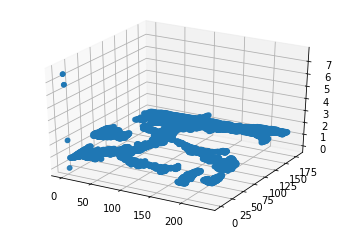

In [2]:
%matplotlib inline

TREE_DIR = './samples'
# Note: doing height x width for convenient indexing, this is the reverse of what comes out
#       of the cameras
SHAPE = (180, 240)

"""Note: these could easily be wrong"""
TOF_CAM_DIMS = (4.896, 6.528) # Units are in mm
# TOF_CAM_DIMS = (5.5, 7.3)
# TOF_FOCAL_LEN = 1.6           # Units are in mm
TOF_FOCAL_LEN = 5

def read_tree_sample(sample_num, raw_data=False):
    sample_data = glob.glob('{0}/Capture_Sample_{1}*'.format(TREE_DIR, sample_num))
    
    print(sample_data)
    
    data = {i: None for i in range(len(sample_data))}
    
    for i, data_file in enumerate(sample_data):
        if raw_data:
            data[i] = np.genfromtxt(sample_data[i], dtype=np.short, delimiter=',')
        else:
            data[i] = np.genfromtxt(sample_data[i], delimiter=',')
   
    return data
    
# TODO: remove points with confidence beneath a certain threshold
    
def extract_data(sample, capture, raw_data=False):
    # Read in the data
    data = read_tree_sample(sample, raw_data)
    if raw_data:
        print('hiy')
        # Transform the raw data into depth and confidence values
        d = data[capture]
        depth_range = np.array(d[:,2] & 0x1FFF, dtype=np.float32)/1000
    else:
        depth_range = data[capture][:,2]

    return data[capture][:,0], data[capture][:,1], depth_range.astype(np.float64)


# Indicate whether raw data is being used
raw_data = True

# Sample
sample = 5

# Data file
capture = 0

x, y, depth = extract_data(sample, capture, raw_data=raw_data)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
    
mask = depth != 0
ax.scatter(x[mask], y[mask], depth[mask])

plt.show()

(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        4.660e+02, 2.000e+00, 0.000e+00, 5.000e+01, 3.260e+02, 1.140e+02,
        5.640e+02, 1.390e+03, 2.170e+03, 1.288e+03, 8.460e+02, 1.558e+03,
        1.254e+03, 9.880e+02, 6.260e+02, 6.920e+02, 7.980e+02, 7.020e+02,
        6.380e+02, 3.800e+02, 3.680e+02, 3.960e+02, 1.800e+02, 1.420e+02,
        2.740e+02, 1.880e+02, 6.180e+02, 1.028e+03, 2.820e+02, 7.600e+01,
        2.200e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

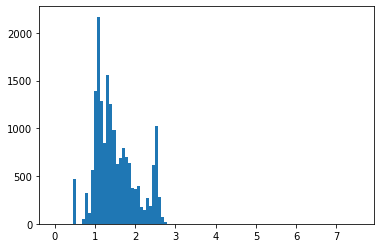

In [3]:
plt.hist(depth[mask], 100)

['./samples/Capture_Sample_5_38', './samples/Capture_Sample_5_39', './samples/Capture_Sample_5_41', './samples/Capture_Sample_5_40', './samples/Capture_Sample_5_42']
hiy
height_m_per_pix 2.7199999999999997e-05
width_m_per_pix 2.7199999999999997e-05
Object inds: min = [45], max = [159]
The width of the object = [0.0031008]
The middle pixel index in height is 119.5
case 1 = [False]
case 2 = [ True]
case 3 = [False]
distance to plane intersection 0.005068356356847849
theta_l = [0.38034605]
theta_r = [0.20888966]
theta = [0.58923571]
dist_l = [0.00545844]; dist_r = [0.00518098]
dists from tree d_l = [1.55499995]; d_r  [1.57500005]
Poorly estimated DBH (cm) = [122.33384229]


'Old focal length estimation code'

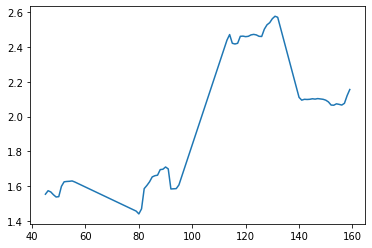

In [4]:
""" Approximating the DBH using approximate data """

MIN_DIST = 0.5
MAX_DIST = 4

# This uses non-raw data
raw_data = True

# Sample
sample = 5

# Data file
capture = 0

x, y, depth = extract_data(sample, capture, raw_data=raw_data)

height_mm_per_pix = TOF_CAM_DIMS[1] / SHAPE[1]
height_m_per_pix = height_mm_per_pix / 1000
print('height_m_per_pix {}'.format(height_m_per_pix))

width_mm_per_pix = TOF_CAM_DIMS[0] / SHAPE[0]
width_m_per_pix = width_mm_per_pix / 1000
print('width_m_per_pix {}'.format(width_m_per_pix))

sample_height = 120
data_reconstruct = np.reshape(depth, SHAPE)
sample_inds = np.argwhere(np.logical_and(data_reconstruct[sample_height,:] >= MIN_DIST,
                                         data_reconstruct[sample_height,:] <= MAX_DIST).astype(np.int))

dists = data_reconstruct[sample_height, sample_inds]
plt.plot(sample_inds, dists)
print('Object inds: min = {0}, max = {1}'.format(sample_inds[0], sample_inds[-1]))

d_l = sample_inds[0]
d_r = sample_inds[-1]

# camera_obj_width = (d_r - d_l + 1)*height_m_per_pix
camera_obj_width = (d_r - d_l)*height_m_per_pix
print('The width of the object = {}'.format(camera_obj_width))

mid_pix_height = (SHAPE[1] - 1) / 2
print('The middle pixel index in height is {}'.format(mid_pix_height))

mid_pix_width = (SHAPE[0] - 1)/2

# Lengths to the left and right of the midpoint
# len_l = (abs(d_l - mid_pix_height)+1)*height_m_per_pix
# len_r = (abs(d_r - mid_pix_height)+1)*height_m_per_pix
len_l = (abs(d_l - mid_pix_height))*height_m_per_pix
len_r = (abs(d_r - mid_pix_height))*height_m_per_pix

# The cases for estimating the angles
case_1 = (d_l - mid_pix_height < 0) and (d_r - mid_pix_height < 0) # Both are to the left of the center
case_2 = (d_l - mid_pix_height < 0) and (d_r - mid_pix_height > 0) # One is to the left, one to the right of center
case_3 = (d_l - mid_pix_height > 0) and (d_r - mid_pix_height > 0) # Both are to the right of center

print('case 1 = {}'.format(case_1))
print('case 2 = {}'.format(case_2))
print('case 3 = {}'.format(case_3))

# dist_height = (abs(mid_pix_width - sample_height)+1)*width_mm_per_pix
dist_height = (abs(mid_pix_width - sample_height))*width_mm_per_pix
dist_plane_intersect = np.sqrt(dist_height**2 + TOF_FOCAL_LEN**2)/1000
print('distance to plane intersection {}'.format(dist_plane_intersect))

theta = 0
theta_l = np.arctan(len_l / dist_plane_intersect)
theta_r = np.arctan(len_r / dist_plane_intersect)
theta = case_1*(theta_l - theta_r) + case_2*(theta_l + theta_r) + case_3*(theta_r - theta_l)

print('theta_l = {}'.format(theta_l))
print('theta_r = {}'.format(theta_r))
print('theta = {}'.format(theta))

# Distances to the image planes
dist_l = np.sqrt(len_l**2 + dist_plane_intersect**2)
dist_r = np.sqrt(len_r**2 + dist_plane_intersect**2)

print('dist_l = {0}; dist_r = {1}'.format(dist_l, dist_r))

# Lengths from the camera center to the edges of the object
tot_dist_l = dist_l + dists[0]
tot_dist_r = dist_r + dists[-1]

print('dists from tree d_l = {0}; d_r  {1}'.format(dists[0], dists[1]))

# Use the law of cosines to estimate the DBH
dbh = np.sqrt(tot_dist_l**2 + tot_dist_r**2 - 2*tot_dist_l*tot_dist_r*np.cos(theta))
print('Poorly estimated DBH (cm) = {}'.format(100*dbh))


"""Old focal length estimation code"""
# Object width for the estimation
# OBJ_WIDTH = 53.98
# OBJ_DIST  = 85.60

# Calculate the camera center in image-plane centered coordinates
# m_plus = (2*OBJ_DIST)/(OBJ_WIDTH - camera_obj_width)
# m_mins = -m_plus

# x_c = 0

# y_c = m_plus*(x_c-(camera_obj_width/2))

# print('focal length = {0}mm'.format(y_c))

In [5]:
# Shape we upsample to for depth estimation
UPSAMPLE_SHAPE = (640, 480)

# Camera intrinsic parameters
CAMERA_PARAMS = {
    'ALPH_X': 492.68967,
    'ALPH_Y': 492.6062,
    'U0': 323.59485,
    'V0': 234.65974
}

# Distance bounds for the trees (will be done by segmentation later)
MIN_DIST = 0.1
MAX_DIST = 4

def get_depth_map(sample, capture, raw_data=True, seg_fun=None, seg_params=None):
    x, y, depth = extract_data(sample, capture, raw_data=raw_data)
    
    # Reshape to an image
    depth = np.reshape(depth, SHAPE)
    
    # If requested, get the segmentation of the depth image
    seg = None
    if seg_fun != None:
        seg = seg_fun(depth, seg_params)
    
    # Upsample
    depth = np.array(Image.fromarray(depth).resize(UPSAMPLE_SHAPE))
    
    X_ind = np.reshape(np.repeat(np.arange(UPSAMPLE_SHAPE[0]), UPSAMPLE_SHAPE[1]),
                       (UPSAMPLE_SHAPE[0], UPSAMPLE_SHAPE[1])).T
    Y_ind = np.reshape(np.repeat(np.arange(UPSAMPLE_SHAPE[1]), UPSAMPLE_SHAPE[0]),
                       (UPSAMPLE_SHAPE[1], UPSAMPLE_SHAPE[0]))
    
    # Estimate X,Y position of each depth point
    X = (depth*(X_ind - CAMERA_PARAMS['U0'])/CAMERA_PARAMS['ALPH_X'])
    Y = (depth*(Y_ind - CAMERA_PARAMS['V0'])/CAMERA_PARAMS['ALPH_Y'])
    
    if seg_fun == None:
        return X, Y, depth
    else:
        return X, Y, depth, seg

def estimate_dbh_at_y(X, Y, depth, sample_height, seg=None, seg_label=None):
    
    # Indices in the unsegmented image 
    if seg == None:
        sample_inds = np.argwhere(np.logical_and(depth[sample_height,:] >= MIN_DIST,
                                             depth[sample_height,:] <= MAX_DIST).astype(np.int))
    else:
        sample_inds = np.argwhere((seg[sample_height,:] == seg_label).astype(np.int))
    
    # x coordinates of the edge points
    x_l = X[sample_height, sample_inds[0]]
    x_r = X[sample_height, sample_inds[-1]]

    # The depths of the edge points
    d_l = depth[sample_height, sample_inds[0]]
    d_r = depth[sample_height, sample_inds[-1]]
    
    # Estimate the DBH
    dbh = np.sqrt((x_l - x_r)**2 + (d_l - d_r)**2)
    
    # return the result in cm
    return 100*float(dbh)

# This uses non-raw data
raw_data = True

# Sample
sample = 5

# Data file
capture = 0
    
# Sample height
sample_height = 240

# Get the world (X, Y, Z) coordinates
X, Y, depth = get_depth_map(sample, capture, raw_data=raw_data)

# Estimate the DBH at the specified sample height
dbh = estimate_dbh_at_y(X, Y, depth, sample_height)

print('DBH estimate = {:.3f}cm'.format(dbh))
    

['./samples/Capture_Sample_5_38', './samples/Capture_Sample_5_39', './samples/Capture_Sample_5_41', './samples/Capture_Sample_5_40', './samples/Capture_Sample_5_42']
hiy
DBH estimate = 149.080cm


In [6]:
"""Estimating the DBH """

from PIL import Image

UPSAMPLE_SHAPE = (640, 480)

# Camera intrinsic parameters
CAMERA_PARAMS = {
    'ALPH_X': 492.68967,
    'ALPH_Y': 492.6062,
    'U0': 323.59485,
    'V0': 234.65974
}

# Distance bounds for the trees (will be done by segmentation later)
MIN_DIST = 0.5
MAX_DIST = 4

# This uses non-raw data
raw_data = True

# Sample
sample = 5

# Data file
capture = 0

x, y, depth = extract_data(sample, capture, raw_data=raw_data)

# Reshape to an image
depth = np.reshape(depth, SHAPE)

# plt.imshow(depth)
# print(depth.shape)

# Resize
depth = np.array(Image.fromarray(depth).resize(UPSAMPLE_SHAPE))

# Indices at the sample y-value where we estimate the DBH
sample_height = 240
sample_inds = np.argwhere(np.logical_and(depth[sample_height,:] >= MIN_DIST,
                                         depth[sample_height,:] <= MAX_DIST).astype(np.int))


X_ind = np.reshape(np.repeat(np.arange(UPSAMPLE_SHAPE[0]), UPSAMPLE_SHAPE[1]), (UPSAMPLE_SHAPE[0], UPSAMPLE_SHAPE[1])).T
Y_ind = np.reshape(np.repeat(np.arange(UPSAMPLE_SHAPE[1]), UPSAMPLE_SHAPE[0]), (UPSAMPLE_SHAPE[1], UPSAMPLE_SHAPE[0]))


# print(np.arange(SHAPE[1]))
# print(Y_ind)
X = (depth*(X_ind - CAMERA_PARAMS['U0'])/CAMERA_PARAMS['ALPH_X'])
Y = (depth*(Y_ind - CAMERA_PARAMS['V0'])/CAMERA_PARAMS['ALPH_Y'])

# Compute the distances
x_l = X[sample_height, sample_inds[0]]
x_r = X[sample_height, sample_inds[-1]]

d_l = depth[sample_height, sample_inds[0]]
d_r = depth[sample_height, sample_inds[-1]]

# Estimate the DBH
dbh = np.sqrt((x_l - x_r)**2 + (d_l - d_r)**2)

print('the estimated DBH = {:.3f}cm'.format(100*float(dbh)))

# print(depth.shape)
# a = plt.hist(depth)

['./samples/Capture_Sample_5_38', './samples/Capture_Sample_5_39', './samples/Capture_Sample_5_41', './samples/Capture_Sample_5_40', './samples/Capture_Sample_5_42']
hiy
the estimated DBH = 149.080cm


['./samples/Capture_Sample_5_38', './samples/Capture_Sample_5_39', './samples/Capture_Sample_5_41', './samples/Capture_Sample_5_40', './samples/Capture_Sample_5_42']
hiy


/Users/connor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


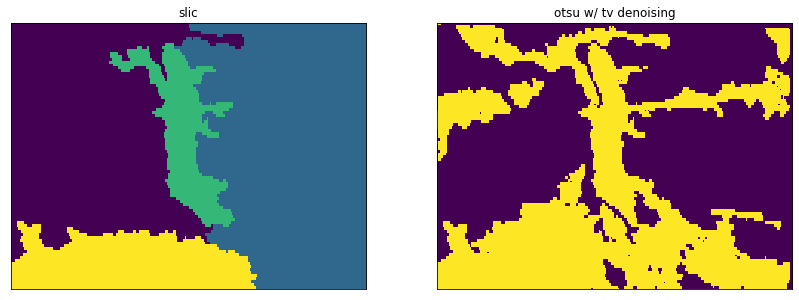

In [7]:
%matplotlib inline

# Part 1: Simple image segmentation to estimate diameter from this angle
sample_num = 5
data_num = 3

raw_data = True

def get_data(sample, capture, raw_data=False):
    X, Y, data = get_depth_map(sample, capture, raw_data=raw_data)
    
    return data

# def get_data(sample_num, data_num, raw_data=False, confidence=False):
#     data = read_tree_sample(sample_num, raw_data=raw_data)
#     print(type(data[data_num]))
#     d = data[data_num]
#     print(d.shape)
    
    
#     if confidence:
#         im = np.reshape(d[:,2:], (*SHAPE, 2))
#     else:
#         im = np.reshape(d[:,2], SHAPE)
        
#     # If using a raw
#     return im

def segment_slic(im, seg_params):#sigma, compactness, n_segments):
    sigma = seg_params['sigma']
    compactness = seg_params['compactness']
    n_segments = seg_params['n_segments']
    multichannel = False
    return seg.slic(im, n_segments=n_segments, sigma=sigma,
                    compactness=compactness, multichannel=multichannel)
        
def segment_thresh(im):
    im_thresh = filters.threshold_otsu(im) 
    return im > im_thresh

def denoise_tv(im):
    return denoise_tv_chambolle(im, weight=0.3)

sigma = 0 # 0.1
compactness = 0.001
n_segments = 10
seg_params = {
    'sigma': sigma,
    'compactness': compactness,
    'n_segments': n_segments
}

X, Y, im = extract_data(sample_num, data_num, raw_data=raw_data)
im = np.reshape(im, SHAPE)

fig = plt.figure(2, figsize=(14,10))

ax1 = fig.add_subplot(1,2,1)
ax1.title.set_text('slic')
ax1.imshow(segment_slic(im[:,:], seg_params))
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

ax2 = fig.add_subplot(1,2,2)
ax2.title.set_text('otsu w/ tv denoising')
ax2.imshow(segment_thresh(denoise_tv(im[:,:])))
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

fig.show()

/Users/connor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


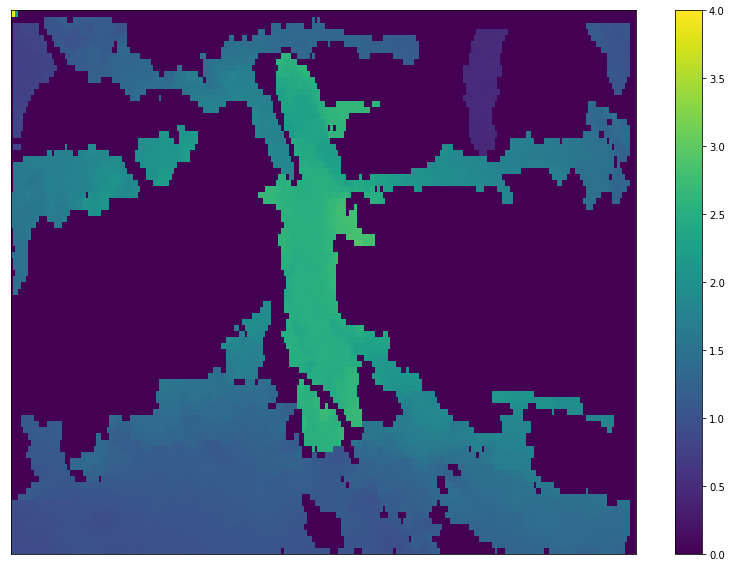

In [8]:
fig = plt.figure(2, figsize=(14,10))

ax = fig.add_subplot(1,1,1)
# ax.title.set_text('Depth Map')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# img = ax.imshow(im[:,:], cmap='jet')
img = ax.pcolormesh(im[::-1,:], vmin=0, vmax=4)


fig.colorbar(img)
# cb_ax.ax.set_ylim(0, 4)

fig.show()

plt.savefig('./Sample5DepthMap.png')


['./samples/Capture_Sample_5_38', './samples/Capture_Sample_5_39', './samples/Capture_Sample_5_41', './samples/Capture_Sample_5_40', './samples/Capture_Sample_5_42']
hiy


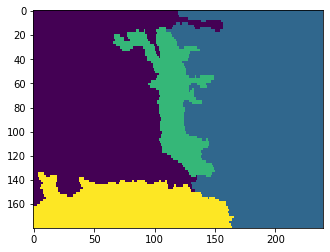

In [9]:
"""
Get depth map and segmentation
"""

sample = 5
capture = 3
raw_data = True

# Get the depth map and segmentation
X, Y, depth, seg = get_depth_map(sample, capture, raw_data=raw_data,
                                 seg_fun=segment_slic, seg_params=seg_params)

# Choose the sample height by cheating
sample_height = 90

# Choose the sample segmentation value by cheating
seg_label = seg[seg.shape[0]/2,seg.shape[1]/2]

print('seg label = {}'.format(seg_label))

# Extract the depth values along this segmentation


In [10]:
# I don't believe in otsu for this application


In [11]:
# ## Comparison of parameter variation for each data point


# im = get_data(sample_num, data_num, confidence=True)
# fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 15),
#                        sharex=True, sharey=True)

# for i in range(1, 6):
#     im = get_data(i, 0, confidence=True)
#     im_d = im[:,:,0]   # depth only, no confidence percent
    
#     ax[i-1, 0].imshow(im_d)
#     ax[i-1, 1].imshow(seg.slic(im_d, n_segments=9, sigma=0.1))
#     ax[i-1, 2].imshow(seg.slic(im, n_segments=9, sigma=0.001, multichannel=True))
#     ax[i-1, 3].imshow(segment_thresh(im_d))
    
# fig.tight_layout()
# plt.show()


In [12]:
# data = read_tree_sample(sample_num)
# d = data[data_num]
# im = np.reshape(d[:,2], SHAPE)
# print()